In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
import pyLDAvis.gensim_models, pyLDAvis, multiprocessing, gensim, spacy, ast
import warnings, logging, seaborn, shutil, pickle, pprint, time, os, re
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## TV Commentary: Topic Modeling with Latent Dirichlet Allocation
#### Let's choose the right number of topics for our LDA model using Coherence Scores, then run LDA and visualize it with pyLDAvis.
#### White, Non-White and All-QBs  Separated:
- #### 1. White Quarterbacks
    - 1.1. Preprocessing
    - 1.2. Coherence Scores
    - 1.3. Latent Dirichlet Allocation (LDA)
    - 1.4. Visualizations 
    <br/><br/>
- #### 2. Non-White Quarterbacks
    - 2.1. Preprocessing
    - 2.2. Coherence Scores
    - 2.3. Latent Dirichlet Allocation (LDA)
    - 2.4. Visualizations
    <br/><br/>
- #### 3. All-Quarterbacks
    - 3.1. Preprocessing
    - 3.2. Coherence Scores
    - 3.3. Latent Dirichlet Allocation (LDA)
    - 3.4. Visualizations

In [8]:
# Load our dataset
path = 'dataset-football_commentary'
filename = 'qb_mentions_12.csv'

df = pd.read_csv(os.path.join(path, filename)).drop('Mention_Cleaned', axis=1)
df.head(3)

,Player,Year,Race,Mention
0,Matt Leinart,2006,White,"['seen', 'a', 'lot,', 'and', 'weve', 'seen', 'him', 'win', 'a', 'lot', 'that', 's', '&gt;&gt;', 'and,', 'mike,', 'he', 'has', 'been', 'on', 'top', '<player>', 'all', 'you']"
1,Matt Leinart,2006,White,"['lot', 'that', 's', '<player>', '&gt;&gt;', 'and,', 'mike,', 'he', 'has', 'been', 'on', 'top', 'all', 'you', 'need', 'to', 'do', 'is', 'look', 'at', 'two', 'simple', 'numbers']"
2,Matt Leinart,2006,White,"['all', 'you', 'need', 'to', 'do', 'is', 'look', 'at', 'two', 'simple', 'numbers', 'in', 's', 'life', '372', 'as', 'a', 'starter', 'that', 's', 'what', 'this', 'man']"


In [9]:
# Convert our "strange" string format to a coherent text, removing special characters (tag, etc.)
def join_text(text):
    pattern = '^[^a-zA-Z0-9]'
    return ' '.join(token for token in ast.literal_eval(text) if not re.match(pattern, token))

# Convert to list
df['Mention_Cleaned'] = df['Mention'].apply(join_text)
df.head(3)

,Player,Year,Race,Mention,Mention_Cleaned
0,Matt Leinart,2006,White,"['seen', 'a', 'lot,', 'and', 'weve', 'seen', 'him', 'win', 'a', 'lot', 'that', 's', '&gt;&gt;', 'and,', 'mike,', 'he', 'has', 'been', 'on', 'top', '<player>', 'all', 'you']","seen a lot, and weve seen him win a lot that s and, mike, he has been on top all you"
1,Matt Leinart,2006,White,"['lot', 'that', 's', '<player>', '&gt;&gt;', 'and,', 'mike,', 'he', 'has', 'been', 'on', 'top', 'all', 'you', 'need', 'to', 'do', 'is', 'look', 'at', 'two', 'simple', 'numbers']","lot that s and, mike, he has been on top all you need to do is look at two simple numbers"
2,Matt Leinart,2006,White,"['all', 'you', 'need', 'to', 'do', 'is', 'look', 'at', 'two', 'simple', 'numbers', 'in', 's', 'life', '372', 'as', 'a', 'starter', 'that', 's', 'what', 'this', 'man']",all you need to do is look at two simple numbers in s life 372 as a starter that s what this man


In [10]:
# Split the dataset for white and non-white players
w = df[df['Race'] == 'White'].reset_index(drop=True)
nw = df[df['Race'] == 'Non-White'].reset_index(drop=True)

## 1. White Quarterbacks

In [11]:
# Select white quarterbacks
df = w

### 1.1. Preprocessing

In [12]:
def sent_to_words(sentences):

    for text in sentences:
        text = re.sub(r'class=".*?"', '', text)
        text = re.sub(r'style=".*?"', '', text)
        text = re.sub(r'id=".*?"', '', text)
        text = re.sub(r'of-\d+', '', text)
        text = re.sub(r'\d+-', '', text)
        text = re.sub(r'\d+st', '', text)
        text = re.sub(r'\d+nd', '', text)
        text = re.sub(r'\d+rd', '', text)
        text = re.sub(r'\d+th', '', text) 
        text = re.sub(r'\S*@\S*\s?', '', text)  
        text = re.sub(r'\s+', ' ', text)  
        text = re.sub(r"\'", "", text)       
        text = gensim.utils.simple_preprocess(str(text), deacc=True) 
        yield(text)  

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Convert to list
data = df['Mention_Cleaned'].values.tolist()
data_words = list(sent_to_words(data))

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Remove Stopwords, form Bigrams, Trigrams and Lemmatization
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [15]:
# To find the best number of topics, we run a "CoherenceModel" with different evaluation scores
coherence_values = []

for num_topics in range(1, 7):
    model = LdaMulticore(corpus=corpus, 
                         id2word=id2word, 
                         num_topics=num_topics, random_state=24)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=data_words, 
                                          dictionary=id2word, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=data_words, 
                                       dictionary=id2word, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

1 -3.0292647841913944 0.07685140371175099
2 -3.1402167948558555 0.058776564071785595
3 -3.206082024544106 0.06264819969096101
4 -3.3250699430596846 0.06798913667423837
5 -3.3954446490711083 0.08173715807931173
6 -3.3499526653302776 0.08857030011924223


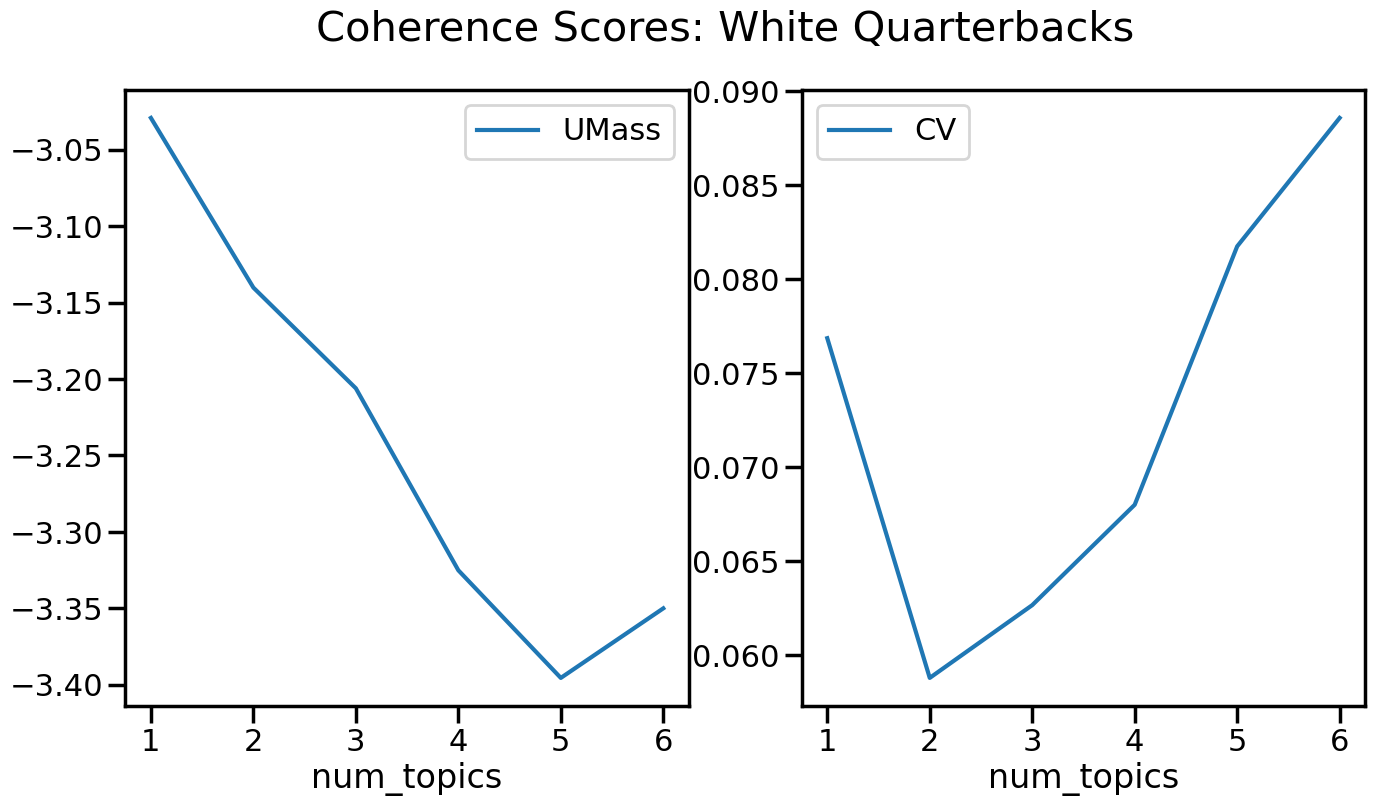

In [26]:
seaborn.set_context('poster') # Use large font

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
# scores['UMass'] = -scores['UMass']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(1, 7))
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(1, 7))

fig.suptitle("Coherence Scores: White Quarterbacks", fontsize=30)
plt.show()

### 1.3. Latent Dirichlet Allocation (LDA)

In [17]:
# Select number of topics
num_topics = 3

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,        # Corpus
                                           id2word=id2word,       # Dictionary
                                           num_topics=num_topics, # Number of topics selected 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,          # Chunksize
                                           passes=100,            # Number of passes
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [18]:
### SAVE CHECKPOINT
checkpoint = '__checkpoints'
path = 'commentary-lda_model_white_qbs'
filename_lda = 'lda_model_white_qbs'
filename_corpus = 'commentary-corpus_white_qbs'

# Create directories to store the model
if os.path.exists(os.path.join(checkpoint, path)):
    shutil.rmtree(os.path.join(checkpoint, path))
    os.mkdir(os.path.join(checkpoint, path))
else:
    os.mkdir(os.path.join(checkpoint, path))

# Let's save a checkpoint of our model and corpus
lda_model.save(os.path.join(checkpoint, path, filename_lda))

with open(os.path.join(checkpoint, filename_corpus + '.pkl'), 'wb') as f:
    pickle.dump(corpus, f)

In [19]:
### LOAD CHECKPOINT
checkpoint = '__checkpoints'
path = 'commentary-lda_model_white_qbs'
filename_lda = 'lda_model_white_qbs'
filename_corpus = 'commentary-corpus_white_qbs'

# Let's load a checkpoint of our model and corpus
lda_model =  gensim.models.LdaModel.load(os.path.join(checkpoint, path, filename_lda))
with open(os.path.join(checkpoint, filename_corpus + '.pkl'), 'rb') as f:
    corpus = pickle.load(f)

In [20]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

warnings.filterwarnings("ignore", category=FutureWarning) 

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.7778,"second, big, touchdown, football, really, quarterback, guy, way, keep, away","[win, top]"
1,1,0,0.8333,"throw, player, game, look, time, field, ball, pressure, great, offense","[look, simple, number]"
2,2,0,0.7629,"throw, player, game, look, time, field, ball, pressure, great, offense","[look, simple, number, life, starter, man]"
3,3,2,0.7078,"second, big, touchdown, football, really, quarterback, guy, way, keep, away","[offensive, give, opportunity, stay, upright, certainly, tool, impressed, heck, way]"
4,4,2,0.7793,"second, big, touchdown, football, really, quarterback, guy, way, keep, away","[eavesdrop, tough, test, bear, wire, sound, back, home]"


In [21]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                             axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9431,"throw, player, game, look, time, field, ball, pressure, great, offense","[miss, field, goal, overtime, gamewinner, eventually, buoniconti, block, field, goal, game, lenny]"
1,1,0.9390,"play, first, back, yard, third, last, year, call, catch, start","[stretch, dinner, together, thursday_night, compare, back, back, derek, jeter, popularity, slow,..."
2,2,0.9387,"second, big, touchdown, football, really, quarterback, guy, way, keep, away","[finalist, second, team, allamerican, tackler, second, listen, lattimore, tackle, defensive_back]"


### 1.4. Visualizations

In [22]:
warnings.filterwarnings("ignore", category=FutureWarning) 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.325540  0.026736       1        1  35.114176
2      0.139262 -0.291051       2        1  32.586469
1      0.186278  0.264314       3        1  32.299355, topic_info=        Term         Freq        Total Category  logprob  loglift
50      play  3158.000000  3158.000000  Default  30.0000  30.0000
41     first  2991.000000  2991.000000  Default  29.0000  29.0000
129    throw  2667.000000  2667.000000  Default  28.0000  28.0000
18      back  2416.000000  2416.000000  Default  27.0000  27.0000
71    player  2605.000000  2605.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
321    bound   284.885638   285.695853   Topic3  -5.2355   1.1273
345    night   238.171834   238.865016   Topic3  -5.4146   1.1272
82      show   251.936268   252.678944   Topic3  -5.3584   1.1272
1148    pull   259.001293   259.858059   Topic3  -5.3307   1.1268
409   cowboy   272.792388   274.574807   Topic3  -5.2788   1.1236

[124 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
334       2  0.997733  able
84        2  0.998680  away
18        3  0.999701  back
315       1  0.998950  ball
45        2  0.999214   big
...     ...       ...   ...
33        2  0.998858  week
49        2  0.999317  well
83        2  0.997917  work
54        3  0.999591  yard
391       3  0.999138  year

[100 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

## 2. Non-White Quarterbacks

In [27]:
# Select non-white quarterbacks
df = nw

### 2.1. Preprocessing

In [28]:
def sent_to_words(sentences):

    for text in sentences:
        text = re.sub(r'class=".*?"', '', text)
        text = re.sub(r'style=".*?"', '', text)
        text = re.sub(r'id=".*?"', '', text)
        text = re.sub(r'of-\d+', '', text)
        text = re.sub(r'\d+-', '', text)
        text = re.sub(r'\d+st', '', text)
        text = re.sub(r'\d+nd', '', text)
        text = re.sub(r'\d+rd', '', text)
        text = re.sub(r'\d+th', '', text) 
        text = re.sub(r'\S*@\S*\s?', '', text)  
        text = re.sub(r'\s+', ' ', text)  
        text = re.sub(r"\'", "", text)       
        text = gensim.utils.simple_preprocess(str(text), deacc=True) 
        yield(text)  

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Convert to list
data = df['Mention_Cleaned'].values.tolist()
data_words = list(sent_to_words(data))

In [29]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Remove Stopwords, form Bigrams, Trigrams and Lemmatization
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [30]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

### 2.2. Coherence Scores

In [32]:
# To find the best number of topics, we run a "CoherenceModel" with different evaluation scores
coherence_values = []

for num_topics in range(1, 7):
    model = LdaMulticore(corpus=corpus, 
                         id2word=id2word, 
                         num_topics=num_topics, random_state=23)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=data_words, 
                                          dictionary=id2word, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=data_words, 
                                       dictionary=id2word, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

1 -3.076270476657988 0.08908982231656234
2 -3.209520776619444 0.06381961294140827
3 -3.4583427903605695 0.08702495318512549
4 -3.457105773991245 0.08998637205108116
5 -3.481470897459728 0.1016245311681935
6 -3.4730789231828534 0.09579770416940887


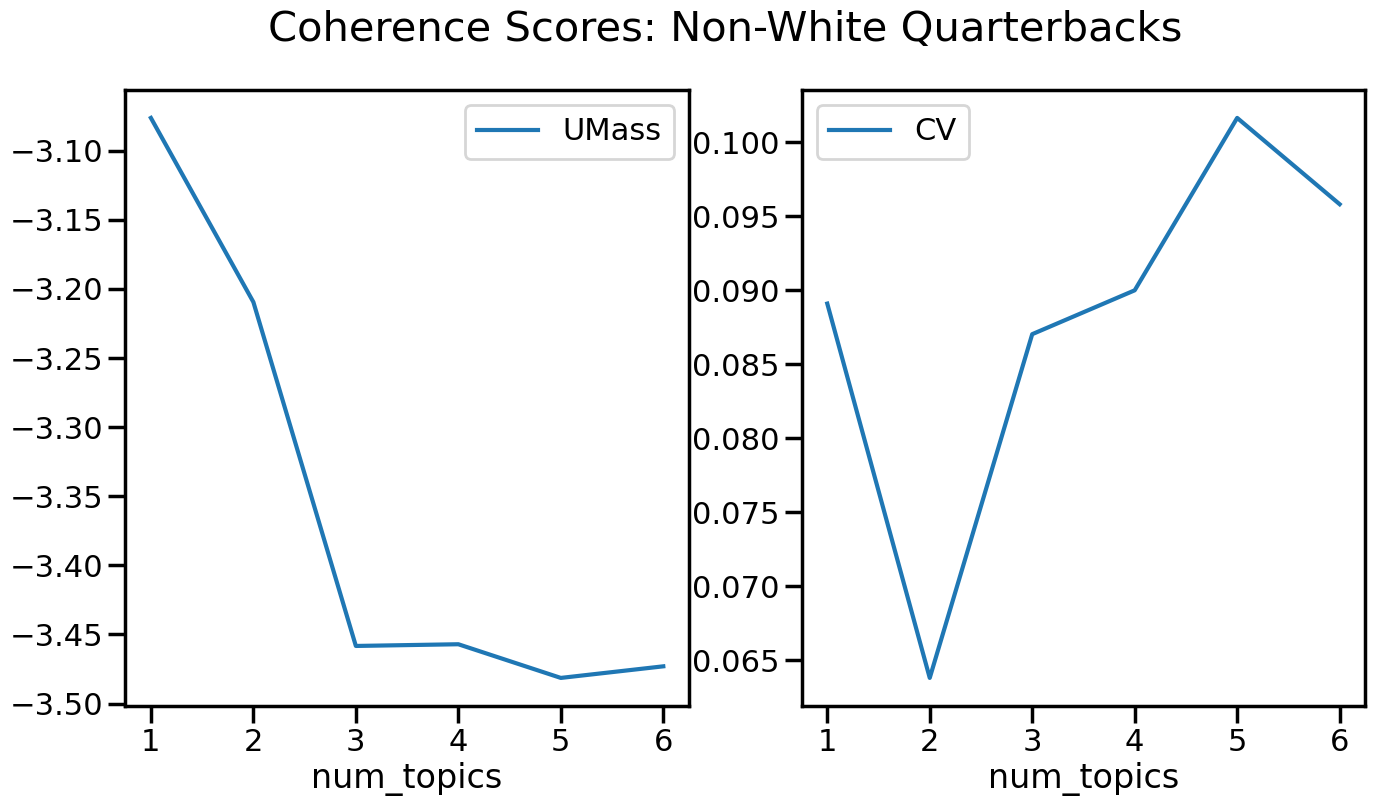

In [40]:
seaborn.set_context('poster') # Use large font

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
# scores['UMass'] = -scores['UMass']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(1, 7))
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(1, 7))

fig.suptitle("Coherence Scores: Non-White Quarterbacks", fontsize=30)
plt.show()

### 2.3. Latent Dirichlet Allocation

In [34]:
# Select number of topics
num_topics = 3

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,        # Corpus
                                           id2word=id2word,       # Dictionary
                                           num_topics=num_topics, # Number of topics selected 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,          # Chunksize
                                           passes=100,            # Number of passes
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [35]:
### SAVE CHECKPOINT
checkpoint = '__checkpoints'
path = 'commentary-lda_model_nonwhite_qbs'
filename_lda = 'lda_model_nonwhite_qbs'
filename_corpus = 'commentary-corpus_nonwhite_qbs'

# Create directories to store the model
if os.path.exists(os.path.join(checkpoint, path)):
    shutil.rmtree(os.path.join(checkpoint, path))
    os.mkdir(os.path.join(checkpoint, path))
else:
    os.mkdir(os.path.join(checkpoint, path))

# Let's save a checkpoint of our model and corpus
lda_model.save(os.path.join(checkpoint, path, filename_lda))

with open(os.path.join(checkpoint, filename_corpus + '.pkl'), 'wb') as f:
    pickle.dump(corpus, f)

In [36]:
### LOAD CHECKPOINT
checkpoint = '__checkpoints'
path = 'commentary-lda_model_nonwhite_qbs'
filename_lda = 'lda_model_nonwhite_qbs'
filename_corpus = 'commentary-corpus_nonwhite_qbs'

# Let's load a checkpoint of our model and corpus
lda_model =  gensim.models.LdaModel.load(os.path.join(checkpoint, path, filename_lda))
with open(os.path.join(checkpoint, filename_corpus + '.pkl'), 'rb') as f:
    corpus = pickle.load(f)

In [37]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

warnings.filterwarnings("ignore", category=FutureWarning) 

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.6749,"first, yard, throw, touchdown, pressure, second, field, quarterback, well, job","[colt, punt, first, great, block]"
1,1,2,0.4436,"time, really, pass, way, number, able, season, lead, defense, year","[position, garrard, first, chase, well, knocked, bound]"
2,2,2,0.7015,"time, really, pass, way, number, able, season, lead, defense, year","[backfield, block, time, wobbly, pass, deflect]"
3,3,1,0.7356,"first, yard, throw, touchdown, pressure, second, field, quarterback, well, job","[kicker, stop, yard, return, yard, first, work, catch, rookie, tight_end]"
4,4,1,0.9013,"first, yard, throw, touchdown, pressure, second, field, quarterback, well, job","[great, throw, well, job, downthefield, throw]"


In [38]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                             axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9373,"player, play, game, look, back, third, ball, big, football, drive","[tremendous, moment, big, criticism, big, pound, play, deddi, ball, game]"
1,1,0.9366,"first, yard, throw, touchdown, pressure, second, field, quarterback, well, job","[backfield, waste, second, pick, usc, far, side, hit, immediately, yard]"
2,2,0.9377,"time, really, pass, way, number, able, season, lead, defense, year","[heisman_trophy, outstanding, defense, talk, mean, perfect, combination, dualthreat, outstanding..."


### 2.4. Visualizations

In [39]:
warnings.filterwarnings("ignore", category=FutureWarning) 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.218363  0.213967       1        1  36.297346
1     -0.299526  0.077113       2        1  35.878261
2      0.081163 -0.291080       3        1  27.824392, topic_info=             Term         Freq        Total Category  logprob  loglift
2           first  1787.000000  1787.000000  Default  30.0000  30.0000
23           yard  1643.000000  1643.000000  Default  29.0000  29.0000
139        player  1576.000000  1576.000000  Default  28.0000  28.0000
53           play  1499.000000  1499.000000  Default  27.0000  27.0000
137          game  1235.000000  1235.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
723        record   183.786708   184.864233   Topic3  -4.9623   1.2734
257      coverage   143.625693   144.470778   Topic3  -5.2088   1.2734
242        ground   213.990874   216.322569   Topic3  -4.8101   1.2684
1484  outstanding   145.476043   146.431780   Topic3  -5.1960   1.2727
1982       senior   202.042734   210.247951   Topic3  -4.8676   1.2394

[126 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
117       3  0.997006  able
266       2  0.998665  away
37        1  0.998563  back
163       1  0.998572  ball
56        1  0.998876   big
...     ...       ...   ...
169       3  0.997994   way
10        2  0.999076  well
534       1  0.994723   win
23        2  0.999419  yard
116       3  0.996409  year

[108 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

## 3. All-Quarterbacks

In [63]:
# Load our dataset
path = 'dataset-football_commentary'
filename = 'qb_mentions_12.csv'

df = pd.read_csv(os.path.join(path, filename)).drop('Mention_Cleaned', axis=1)
df.head(3)

,Player,Year,Race,Mention
0,Matt Leinart,2006,White,"['seen', 'a', 'lot,', 'and', 'weve', 'seen', 'him', 'win', 'a', 'lot', 'that', 's', '&gt;&gt;', ..."
1,Matt Leinart,2006,White,"['lot', 'that', 's', '<player>', '&gt;&gt;', 'and,', 'mike,', 'he', 'has', 'been', 'on', 'top', ..."
2,Matt Leinart,2006,White,"['all', 'you', 'need', 'to', 'do', 'is', 'look', 'at', 'two', 'simple', 'numbers', 'in', 's', 'l..."


In [64]:
# Convert our "strange" string format to a coherent text, removing special characters (tag, etc.)
def join_text(text):
    pattern = '^[^a-zA-Z0-9]'
    return ' '.join(token for token in ast.literal_eval(text) if not re.match(pattern, token))

# Convert to list
df['Mention_Cleaned'] = df['Mention'].apply(join_text)
df.head(3)

,Player,Year,Race,Mention,Mention_Cleaned
0,Matt Leinart,2006,White,"['seen', 'a', 'lot,', 'and', 'weve', 'seen', 'him', 'win', 'a', 'lot', 'that', 's', '&gt;&gt;', ...","seen a lot, and weve seen him win a lot that s and, mike, he has been on top all you"
1,Matt Leinart,2006,White,"['lot', 'that', 's', '<player>', '&gt;&gt;', 'and,', 'mike,', 'he', 'has', 'been', 'on', 'top', ...","lot that s and, mike, he has been on top all you need to do is look at two simple numbers"
2,Matt Leinart,2006,White,"['all', 'you', 'need', 'to', 'do', 'is', 'look', 'at', 'two', 'simple', 'numbers', 'in', 's', 'l...",all you need to do is look at two simple numbers in s life 372 as a starter that s what this man


### 3.1. Preprocessing

In [65]:
def sent_to_words(sentences):

    for text in sentences:
        text = re.sub(r'class=".*?"', '', text)
        text = re.sub(r'style=".*?"', '', text)
        text = re.sub(r'id=".*?"', '', text)
        text = re.sub(r'of-\d+', '', text)
        text = re.sub(r'\d+-', '', text)
        text = re.sub(r'\d+st', '', text)
        text = re.sub(r'\d+nd', '', text)
        text = re.sub(r'\d+rd', '', text)
        text = re.sub(r'\d+th', '', text) 
        text = re.sub(r'\S*@\S*\s?', '', text)  
        text = re.sub(r'\s+', ' ', text)  
        text = re.sub(r"\'", "", text)       
        text = gensim.utils.simple_preprocess(str(text), deacc=True) 
        yield(text)  

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Convert to list
data = df['Mention_Cleaned'].values.tolist()
data_words = list(sent_to_words(data))

In [66]:
### SAVE CHECKPOINT
checkpoint = '__checkpoints'
path = 'commentary-lda_model_overall'
filename_data = 'data_overall'
filename_datawords = 'data_words_overall'

# Create directories to store the model
if os.path.exists(os.path.join(checkpoint, path)):
    shutil.rmtree(os.path.join(checkpoint, path))
    os.mkdir(os.path.join(checkpoint, path))
else:
    os.mkdir(os.path.join(checkpoint, path))

with open(os.path.join(checkpoint, path, filename_data + '.pkl'), 'wb') as f:
    pickle.dump(data, f)

with open(os.path.join(checkpoint, path, filename_datawords + '.pkl'), 'wb') as f:
    pickle.dump(data_words, f)

In [5]:
### LOAD CHECKPOINT
checkpoint = '__checkpoints'
path = 'commentary-lda_model_overall'
filename_data = 'data_overall'
filename_datawords = 'data_words_overall'

with open(os.path.join(checkpoint, path, filename_data + '.pkl'), 'rb') as f:
    data = pickle.load(f)

with open(os.path.join(checkpoint, path, filename_datawords + '.pkl'), 'rb') as f:
    data_words = pickle.load(f)

In [68]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Remove Stopwords, form Bigrams, Trigrams and Lemmatization
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [69]:
### SAVE CHECKPOINT
checkpoint = '__checkpoints'
path = 'commentary-lda_model_overall'
filename_dataready = 'data_ready_overall'

with open(os.path.join(checkpoint, path, filename_dataready + '.pkl'), 'wb') as f:
    pickle.dump(data_ready, f)

In [2]:
### LOAD CHECKPOINT
checkpoint = '__checkpoints'
path = 'commentary-lda_model_overall'
filename_dataready = 'data_ready_overall'

with open(os.path.join(checkpoint, path, filename_dataready + '.pkl'), 'rb') as f:
    data_ready = pickle.load(f)

In [3]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

### 3.2. Coherence Scores

In [6]:
# To find the best number of topics, we run a "CoherenceModel" with different evaluation scores
coherence_values = []

for num_topics in range(3, 10):
    model = LdaMulticore(corpus=corpus, 
                         id2word=id2word, 
                         num_topics=num_topics, random_state=24)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=data_words, 
                                          dictionary=id2word, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=data_words, 
                                       dictionary=id2word, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

3 -3.2943294268912777 0.06661472865694419
4 -3.267741755905103 0.07805047387647049
5 -3.273948970763287 0.08497202839820807
6 -3.4003757269163972 0.09660711413409319
7 -3.433495175302585 0.09686566863248161
8 -3.372602544149274 0.09923083605645922
9 -3.388712485595891 0.10037387185114814


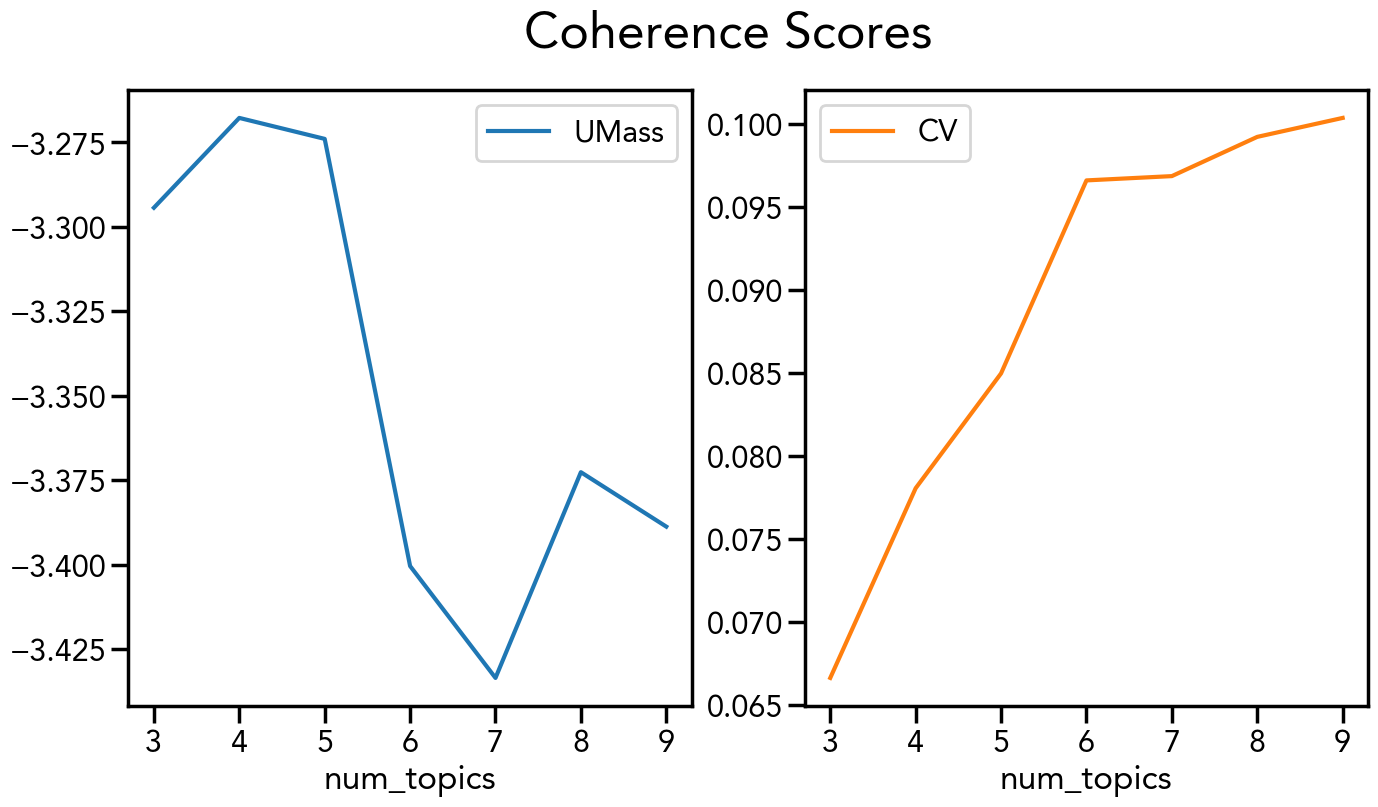

In [7]:
plt.rcParams['font.family'] = 'Avenir'
seaborn.set_context('poster') # Use large font

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
# scores['UMass'] = -scores['UMass']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(3, 10), color='tab:blue')
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(3, 10), color='tab:orange')

fig.suptitle("Coherence Scores", fontsize=36)
plt.show()

### 3.3. Latent Dirichlet Allocation

In [75]:
# Select number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,        # Corpus
                                           id2word=id2word,       # Dictionary
                                           num_topics=num_topics, # Number of topics selected 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,          # Chunksize
                                           passes=100,            # Number of passes
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [76]:
### SAVE CHECKPOINT
checkpoint = '__checkpoints'
path = 'commentary-lda_model_overall'
filename_lda = 'lda_model_overall'
filename_corpus = 'commentary-corpus_overall'

# Let's save a checkpoint of our model and corpus
lda_model.save(os.path.join(checkpoint, path, filename_lda))

with open(os.path.join(checkpoint, filename_corpus + '.pkl'), 'wb') as f:
    pickle.dump(corpus, f)

In [77]:
### LOAD CHECKPOINT
checkpoint = '__checkpoints'
path = 'commentary-lda_model_overall'
filename_lda = 'lda_model_overall'
filename_corpus = 'commentary-corpus_overall'

# Let's load a checkpoint of our model and corpus
lda_model =  gensim.models.LdaModel.load(os.path.join(checkpoint, path, filename_lda))
with open(os.path.join(checkpoint, filename_corpus + '.pkl'), 'rb') as f:
    corpus = pickle.load(f)

In [78]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

warnings.filterwarnings("ignore", category=FutureWarning) 

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.7333,"first, game, touchdown, second, start, pass, long, half, catch, call","[win, top]"
1,1,2,0.5501,"look, thing, year, offense, number, great, team, rush, stop, season","[look, simple, number]"
2,2,2,0.6002,"look, thing, year, offense, number, great, team, rush, stop, season","[look, simple, number, life, starter, man]"
3,3,3,0.6925,"throw, ball, pressure, field, really, way, away, incomplete, give, lead","[offensive, give, opportunity, stay, upright, certainly, tool, impressed, heck, way]"
4,4,1,0.4599,"back, time, big, keep, football, quarterback, drive, job, pocket, well","[eavesdrop, tough, test, bear, wire, sound, back, home]"


In [79]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                             axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9164,"player, play, yard, third, last, guy, pick, let, work, put","[player, player, jump, jump, jump, jump, sander, close, gary]"
1,1,0.9000,"back, time, big, keep, football, quarterback, drive, job, pocket, well","[situation, love, situation, big, well, much, love]"
2,2,0.9154,"look, thing, year, offense, number, great, team, rush, stop, season","[number, look, man, man, corner, isolate, man, man, safety]"
3,3,0.9046,"throw, ball, pressure, field, really, way, away, incomplete, give, lead","[slot, leave, reposition, throw, incomplete, intend, throw, little]"
4,4,0.8999,"first, game, touchdown, second, start, pass, long, half, catch, call","[game, touchdown, touchdown, win, green, win, green]"


### 3.4. Visualizations

In [80]:
warnings.filterwarnings("ignore", category=FutureWarning) 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.218393  0.201911       1        1  21.917271
0     -0.101874 -0.377250       2        1  21.085953
1      0.346403  0.020541       3        1  20.803669
3     -0.113070  0.074543       4        1  19.929589
2      0.086934  0.080254       5        1  16.263519, topic_info=            Term         Freq        Total Category  logprob  loglift
41         first  5342.000000  5342.000000  Default  30.0000  30.0000
69        player  4659.000000  4659.000000  Default  29.0000  29.0000
50          play  4581.000000  4581.000000  Default  28.0000  28.0000
54          yard  4062.000000  4062.000000  Default  27.0000  27.0000
127        throw  3688.000000  3688.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
168         loss   261.779325   262.557580   Topic5  -5.0843   1.8133
453        coach   258.600230   259.369951   Topic5  -5.0965   1.8133
405       cowboy   429.991490   431.272021   Topic5  -4.5880   1.8133
64    penn_state   269.293046   270.132513   Topic5  -5.0560   1.8131
1701        west   446.308970   582.338948   Topic5  -4.5507   1.5502

[186 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
61        3  0.996779   ability
332       4  0.998754      able
522       3  0.998311  actually
577       5  0.997379       air
62        3  0.998125     allow
...     ...       ...       ...
81        2  0.999323      work
54        2  0.999687      yard
389       5  0.999271      year
312       2  0.997327       yet
677       2  0.998493     young

[164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 4, 3])